In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt 

## Xử lý những dữ liệu rác

In [2]:
df = pd.read_csv("/content/drive/MyDrive/DS105_Project/Dataset/Preparing/Original.csv")
df.lpep_dropoff_datetime = pd.DatetimeIndex(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.DatetimeIndex(df.lpep_pickup_datetime)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Để có được biến vận tốc, ta sẽ xử lý những giá trị 0.0 của biến trip_distance (có thể do trục trặc của đông hồ taxi)
#Tu PULocation, DOLocation cua trip_distance = 0 ta doi chieu qua bo du lieu co trip_distance >0, xet trip_duration neu gan voi trip_duration cua du lieu có gia tri 0 do
def ReplaceDistance(df):
  #Tạp thêm biến phát triern trip_duration cho quá trình xử lý trip_distance
  trip_duration = [(i-j).total_seconds() for i,j in zip(df.lpep_dropoff_datetime,df.lpep_pickup_datetime)]
  df['trip_duration'] = trip_duration
  
  nontrip_distance = df[(df.trip_distance == 0) & (df.lpep_dropoff_datetime != df.lpep_pickup_datetime)].index
  for i in nontrip_distance:
    location = df[(df.PULocationID == df.PULocationID[i]) & (df.DOLocationID == df.DOLocationID[i]) & (df.trip_distance!=0)]
    max_time = location[location.trip_duration <= df.trip_duration[i]].trip_duration
    min_time = location[location.trip_duration >= df.trip_duration[i]].trip_duration
    print(f'{i},{max_time.empty},{min_time.empty}')
    if (min_time.empty == True) & (max_time.empty == True):#location == NULL
      df = df.drop(i)
    elif (min_time.empty == False) & (max_time.empty == False):
      max_denta = df.trip_duration[i] - max(max_time.values)
      min_denta = df.trip_duration[i] - min(min_time.values)
      if np.abs(min_denta) > np.abs(max_denta):
        index = location[location.trip_duration.values == max(max_time)].index
        df.trip_distance[i] = df.trip_distance[index[0]]
      else:
        index = location[location.trip_duration.values == min(min_time)].index 
        df.trip_distance[i] = df.trip_distance[index[0]]
    elif min_time.empty == False:
      index = location[location.trip_duration == min(min_time)].index 
      df.trip_distance[i] = df.trip_distance[index[0]]
    elif max_time.empty == False:
      index = location[location.trip_duration == max(max_time)].index 
      df.trip_distance[i] = df.trip_distance[index[0]]
  return df

In [4]:
def Handed_rubish_data(df):
  #Loại bỏ 
  ###cột thuộc tính bị thiếu 100% và dữ liệu trùng
  df.drop(columns = ['ehail_fee'],inplace = True)
  df.drop_duplicates(inplace=True)
  
  ###dữ liệu có thời gian đón khách > thời gian trả khách
  df.drop(df[df.lpep_dropoff_datetime < df.lpep_pickup_datetime].index,inplace = True)

  ###Cac du lieu < 2019
  df = df[pd.DatetimeIndex(df.iloc[:,1]).year >= 2019]

  ###Cac dữ liệu có thời gian đón khác = thời gian trả khách và khoảng cách khác 0
  df.drop(df[(df.lpep_dropoff_datetime == df.lpep_pickup_datetime) & (df.trip_distance != 0)].index,inplace = True)

  ###Cac du lieu co phu phi tat ngen = 2.5
  df.drop(df[df.congestion_surcharge == 2.5].index,inplace=True)

  ###RatecodeID=99
  df.drop(df[df.RatecodeID == 99].index,inplace=True)

  ###mta_tax = 3.55
  df.drop(df[df.mta_tax == 3.55].index,inplace=True)

  #Thay thế giá trị  
  ###Giá trị âm
  negative_list = ['trip_distance',	'fare_amount',	'extra',	'mta_tax',	'tip_amount',	'tolls_amount',	'improvement_surcharge',	'total_amount',	'congestion_surcharge']
  for fe in negative_list:
    df[fe] = df[fe].abs()
  
  ###total_amount < 2.5
  df.drop(df[df.total_amount < 2.5].index,inplace=True)
  
  ##trip_distance = 0 và thời gian đón và trước là khác nhau(Đồng thời tạo thêm biến trip_duration)
  df = ReplaceDistance(df)

  ##payment = 2 va tip_amount != 0
  df.loc[(df.payment_type == 2) & (df.tip_amount != 0),'payment_type'] = 1

  return df
df_ = df.copy()
df_= Handed_rubish_data(df_)


Output hidden; open in https://colab.research.google.com to view.

In [5]:
df_.shape

(1221286, 20)

# Tạo ra các biến mới từ biến hiện tại

In [6]:
def Developed_Variable(df):
  #Speed < 50 : https://nytrafficticket.com/fastest-road-in-america-and-maximum-speed-limits-in-new-york/
  df['speed'] = df.trip_distance / (df.trip_duration /3600)
  df.loc[df.speed == np.Infinity,'speed'] = 0
  df = df[df.speed < 50]

  #Covid
  df.loc[(pd.DatetimeIndex(df.lpep_pickup_datetime).month < 3)|(pd.DatetimeIndex(df.lpep_pickup_datetime).year == 2019),'covid'] = 0
  df.loc[pd.DatetimeIndex(df.lpep_pickup_datetime).month >= 3,'covid'] = 1

  #Hour
  df['hour'] = pd.DatetimeIndex(df.lpep_pickup_datetime).hour

  #Zone
  lookup = pd.read_csv('/content/drive/MyDrive/DS105_Project/Relate_info/taxi+_zone_lookup.csv')
  for i in range(1,266):
    df.loc[df.PULocationID == i,'PU_Borough'] = lookup.Borough[i-1]
    df.loc[df.DOLocationID == i,'DO_Borough'] = lookup.Borough[i-1]
  print(df.isnull().sum())
  #Aiport
  Airport = lookup[(lookup.service_zone == 'Airports')|(lookup.service_zone == 'EWR')].LocationID
  df['airport'] = None
  for i in Airport:
    df.loc[((df.PULocationID == i)|(df.DOLocationID==i)),'airport'] = 1
  df.loc[~(df.airport == 1),'airport'] = 0
  df.airport = df.airport.astype('int64')

  return df
df__ = df_.copy()
df__ = Developed_Variable(df__)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

VendorID                 304425
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag       304425
RatecodeID               304425
PULocationID                  0
DOLocationID                  0
passenger_count          304425
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
payment_type             304425
trip_type                304425
congestion_surcharge     304425
trip_duration                 0
speed                         0
covid                         0
hour                          0
PU_Borough                    0
DO_Borough                    0
dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [7]:
df__.shape

(1213291, 26)

#Xử lý dữ liệu thiếu

In [8]:
def payment_plot(df,fe,target):
  frequency = df[[fe,target]]
  frequency = frequency.groupby(by = fe)[target].value_counts(normalize = True).to_frame()
  frequency.rename(columns = {target:'Count'},inplace=True)
  frequency = pd.concat([frequency,frequency.index.to_frame()],axis = 1)
  sns.catplot(kind = 'bar', x = fe , y = 'Count', hue = target, data=frequency )
null = df__.isnull().sum()[df__.isnull().sum().values!=0].index

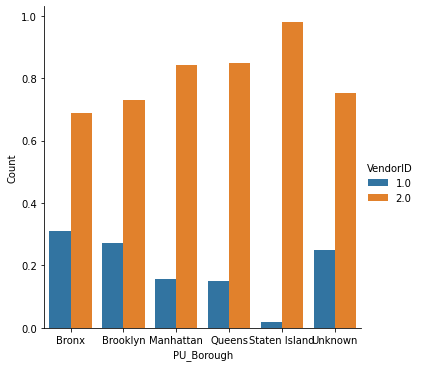

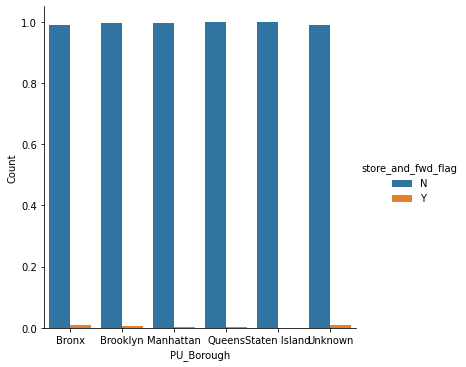

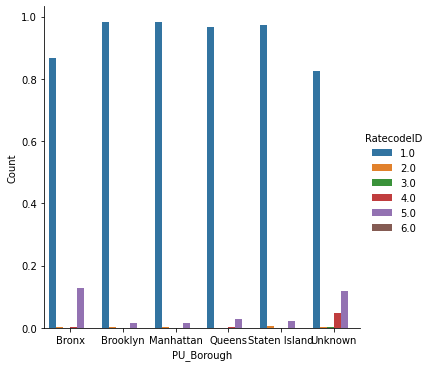

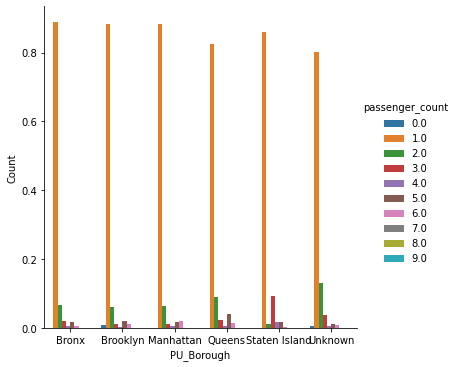

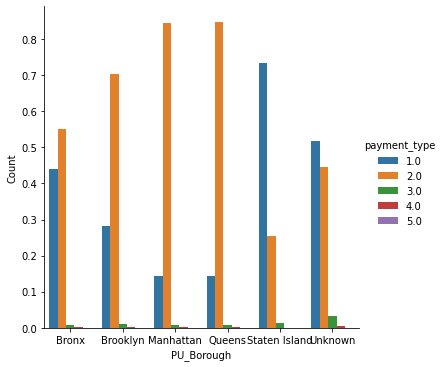

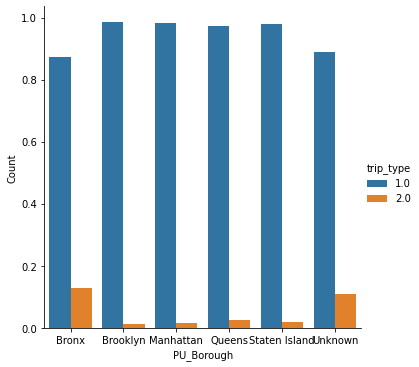

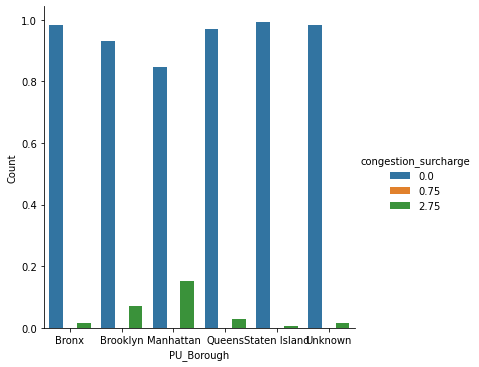

In [9]:
for i in null:
  payment_plot(df__[df__.tip_amount == 0],'PU_Borough',i)
  plt.show()

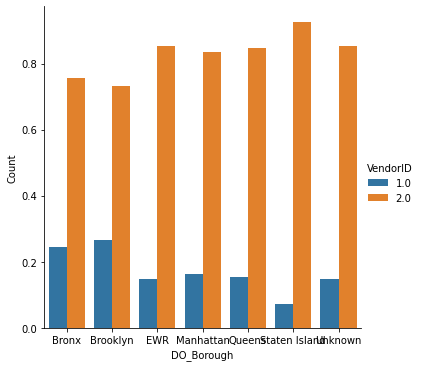

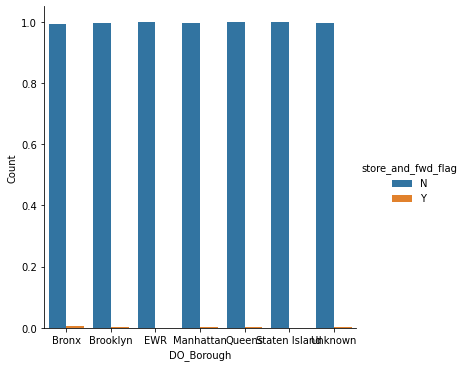

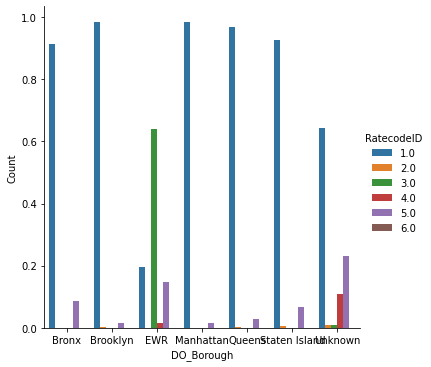

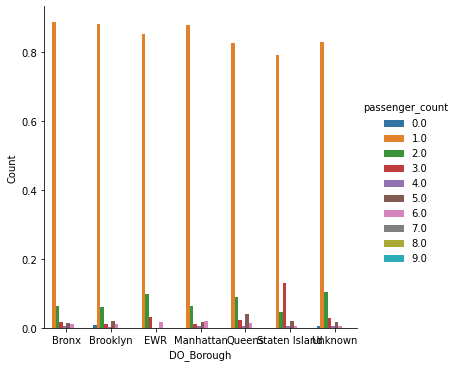

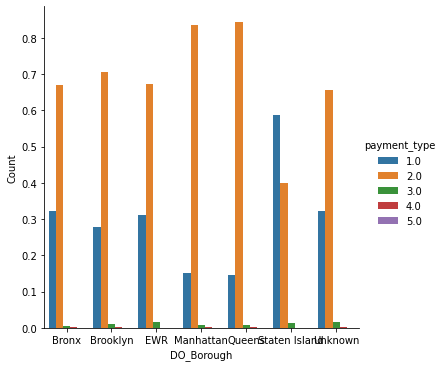

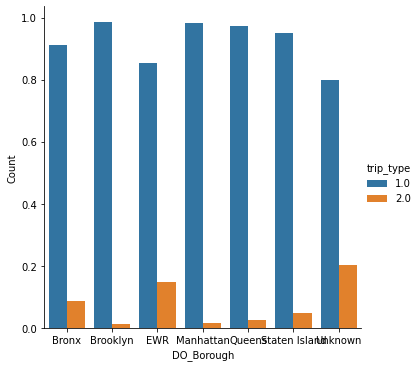

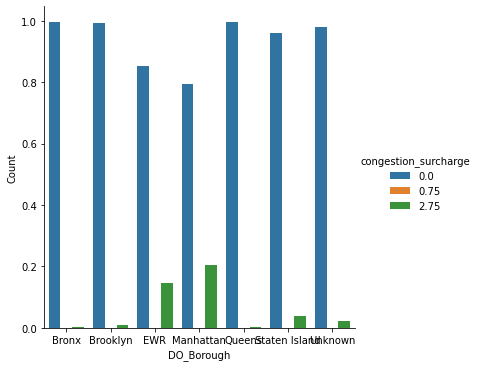

In [10]:
for i in null:
  payment_plot(df__[df__.tip_amount == 0],'DO_Borough',i)
  plt.show()

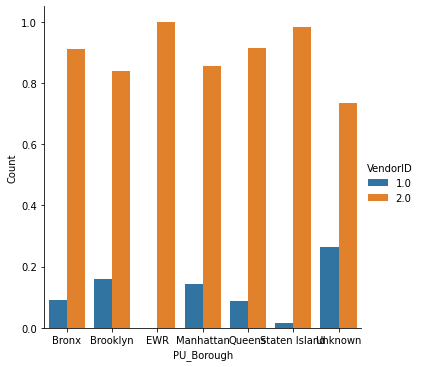

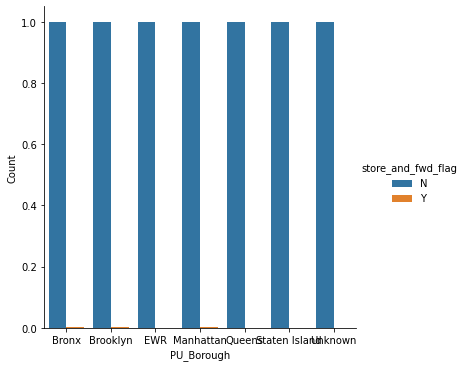

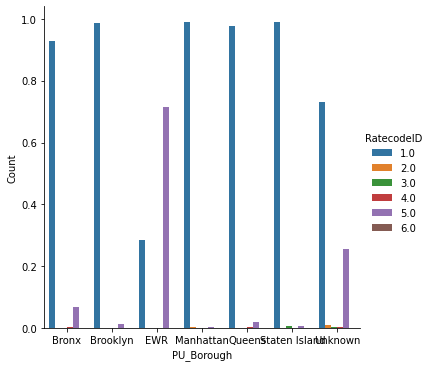

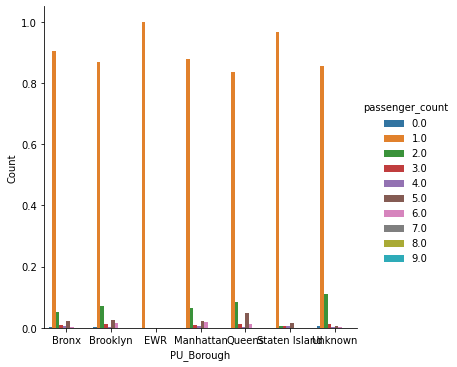

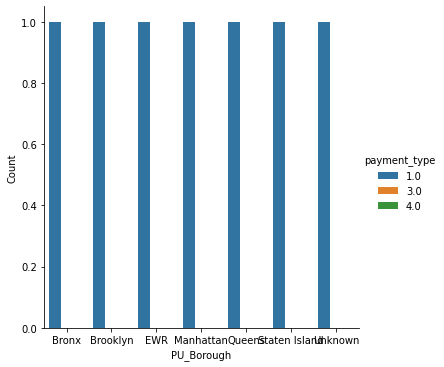

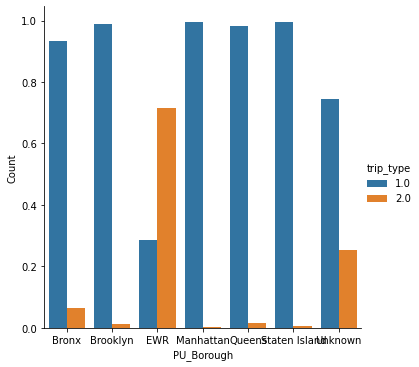

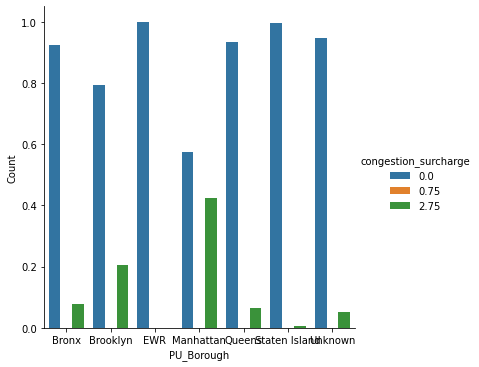

In [11]:
for i in null:
  payment_plot(df__[df__.tip_amount != 0],'PU_Borough',i)
  plt.show()

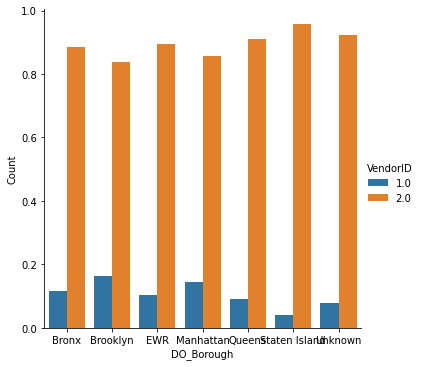

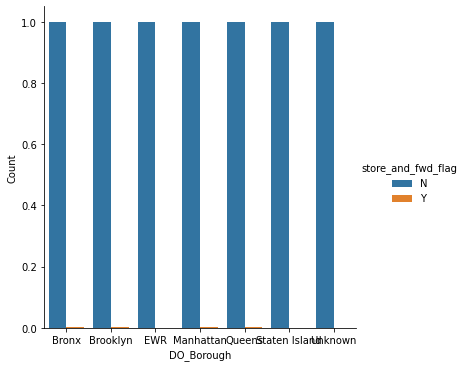

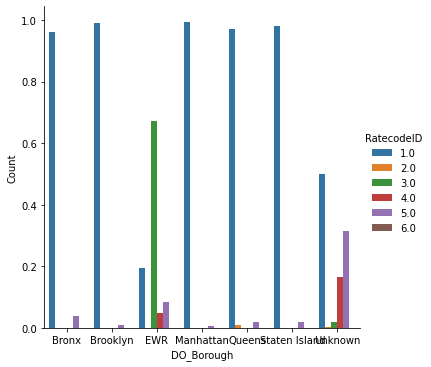

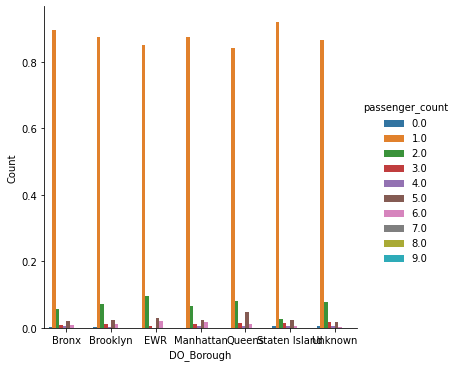

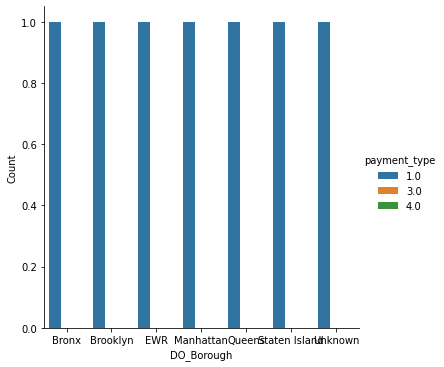

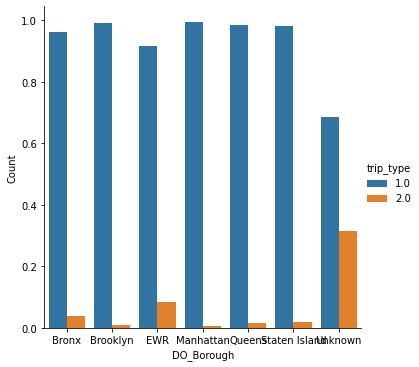

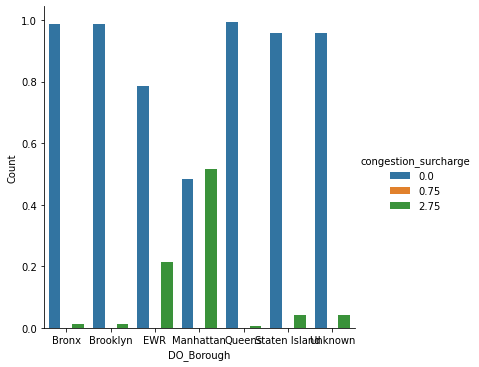

In [12]:
for i in null:
  payment_plot(df__[df__.tip_amount != 0],'DO_Borough',i)
  plt.show()

Sau khi xem xét về ảnh hưởng của biến mục tiêu cùng với biến độc lập Quận(Borough) thì chúng tôi thấy, các thuộc tính này có ảnh hưởng khá nhiều đến các biến bị khuyết dữ liệu do đó chung tôi quyết định thay thế dựa trên biến **tip_amount, PU_Borough, DO_Borough** để thay thế dữ liệu thiếu.

In [13]:
df___ = df__.copy()
print(df___.isnull().sum())
def Handle_Missing_Data(df):
  df.VendorID = df.VendorID.fillna(2)
  df.store_and_fwd_flag = df.store_and_fwd_flag.fillna('N')

  df[(df__.tip_amount > 0) & (df.DO_Borough == 'Manhattan')].congestion_surcharge = df[(df.tip_amount > 0) & (df.DO_Borough == 'Manhattan')].congestion_surcharge.fillna(2.75)
  df.congestion_surcharge = df.congestion_surcharge.fillna(0)

  df.passenger_count = df.passenger_count.fillna(1)

  df.trip_type[(df.tip_amount != 0) & (df.PU_Borough == 'EWR')] = df.trip_type[(df.tip_amount != 0) & (df.PU_Borough == 'EWR')].fillna(2)
  df.trip_type = df.trip_type.fillna(1)

  df[(df.tip_amount != 0) & (df.PU_Borough == 'EWR')].RatecodeID = df[(df.tip_amount != 0) & (df.PU_Borough == 'EWR')].RatecodeID.fillna(5)
  df[df.DO_Borough == 'EWR'].RatecodeID = df[df.DO_Borough == 'EWR'].RatecodeID.fillna(3)
  df.RatecodeID  = df.RatecodeID.fillna(1)

  df.loc[(df__.tip_amount == 0) & ((df.PU_Borough == 'Staten Island')|(df.DO_Borough == 'Staten Island')),'payment_type'] = df[(df.tip_amount == 0) & ((df.PU_Borough == 'Staten Island')|(df.DO_Borough == 'Staten Island'))].payment_type.fillna(1)
  df.loc[(df__.tip_amount == 0) & (df.PU_Borough == 'Unknown'),'payment_type'] = df[(df.tip_amount == 0) & (df.PU_Borough == 'Unknown')].payment_type.fillna(1)
  df.loc[df.tip_amount == 0,'payment_type'] = df[df.tip_amount == 0].payment_type.fillna(2)
  df.loc[df.tip_amount != 0,'payment_type'] = df[df.tip_amount != 0].payment_type.fillna(1)
  return df
df___ = Handle_Missing_Data(df___)
df___.isnull().sum()

VendorID                 304425
lpep_pickup_datetime          0
lpep_dropoff_datetime         0
store_and_fwd_flag       304425
RatecodeID               304425
PULocationID                  0
DOLocationID                  0
passenger_count          304425
trip_distance                 0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
payment_type             304425
trip_type                304425
congestion_surcharge     304425
trip_duration                 0
speed                         0
covid                         0
hour                          0
PU_Borough                    0
DO_Borough                    0
airport                       0
dtype: int64


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

VendorID                 0
lpep_pickup_datetime     0
lpep_dropoff_datetime    0
store_and_fwd_flag       0
RatecodeID               0
PULocationID             0
DOLocationID             0
passenger_count          0
trip_distance            0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
payment_type             0
trip_type                0
congestion_surcharge     0
trip_duration            0
speed                    0
covid                    0
hour                     0
PU_Borough               0
DO_Borough               0
airport                  0
dtype: int64

In [14]:
df___.to_csv('/content/drive/MyDrive/DS105_Project/Dataset/Preparing/DataCleaning.csv',index = False)

###Hướng xử lý ban đầu

In [15]:
#def Handle_Missing_Data(df,null_list):
#  for null in null_list:
#    for PU in df.PU_Borough.unique():
#      if (PU == 'Bronx') | (PU == 'EWR'):
#          bronx_PD = df[(df.PU_Borough == PU) & (df.DO_Borough == PU)][null]
#          bronx_P = df[(df.PU_Borough == PU) & (df.DO_Borough != PU)][null]
#          bronx_D = df[(df.PU_Borough != PU) & (df.DO_Borough == PU)][null]
#
#          if bronx_PD.empty == False:
#            bronx_PD = bronx_PD.fillna(bronx_PD.value_counts().index[0])
#          if bronx_P.empty == False:
#            bronx_P = bronx_P.fillna(bronx_P.value_counts().index[0])
#          if bronx_D.empty == False:
#            bronx_D = bronx_D.fillna(bronx_D.value_counts().index[0])
#      else:
#          df[null] = df[null].fillna(df[null].value_counts().index[0])
#    
#  return df
#df___ = df__.copy()
#df___ = Handle_Missing_Data(df___,null)
#df___.isnull().sum()